# Разработка A/B-тестирования и анализ результатов

## Описание данных

Вы будете работать с тремя таблицами:

- `тут_была_ссылка` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `тут_была_ссылка`.

- `тут_была_ссылка` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `тут_была_ссылка`.

- `тут_была_ссылка` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `тут_была_ссылка`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `тут_была_ссылка`, `тут_была_ссылка`, `тут_была_ссылка`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

sessions_history = pd.read_csv('тут_была_ссылка')

display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [2]:
user_session = sessions_history.groupby('user_id')['session_id'].nunique()

max_user = user_session.idxmax()

user_max_sesion = sessions_history[sessions_history['user_id'] == max_user]

display(user_max_sesion)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

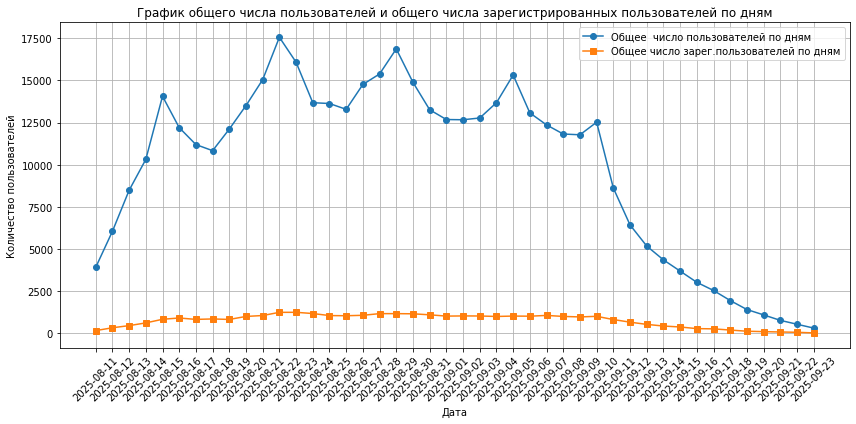

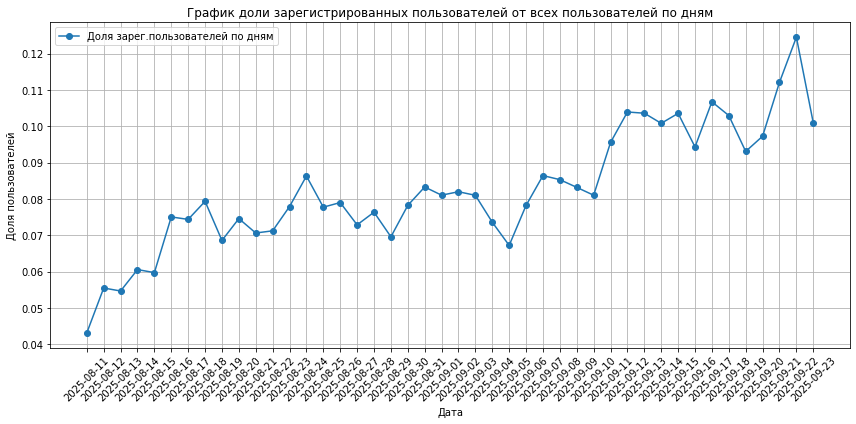

In [3]:
agg_unic_reg = sessions_history.groupby('session_date').agg(
    unic_group = ('user_id', 'nunique'),
    reg_group = ('registration_flag', 'sum')
).reset_index()

agg_unic_reg['dol_reg_users'] = agg_unic_reg['reg_group'] / agg_unic_reg['unic_group']

plt.figure(figsize=(12, 6))
plt.plot(agg_unic_reg['session_date'], agg_unic_reg['unic_group'], label = 'Общее  число пользователей по дням', marker = 'o')
plt.plot(agg_unic_reg['session_date'], agg_unic_reg['reg_group'], label = 'Общее число зарег.пользователей по дням', marker = 's')

plt.title('График общего числа пользователей и общего числа зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.plot(agg_unic_reg['session_date'], agg_unic_reg['dol_reg_users'], label = 'Доля зарег.пользователей по дням', marker = 'o')

plt.title('График доли зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

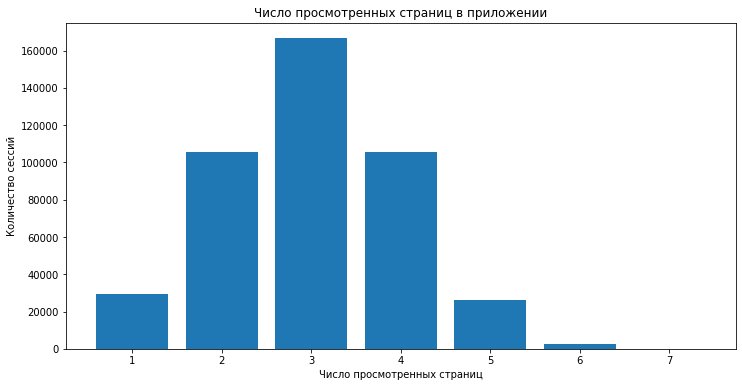

In [4]:
count_sesions_str = sessions_history.groupby('page_counter')['session_id'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(count_sesions_str['page_counter'], count_sesions_str['session_id'])
plt.title('Число просмотренных страниц в приложении')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

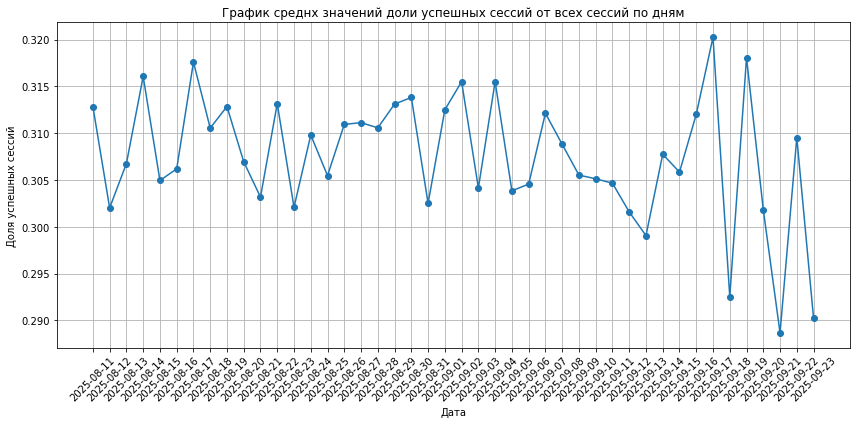

In [5]:
sessions_history['good_session'] = (sessions_history['page_counter'] >=4).astype(int)
mean_dol_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

plt.figure(figsize = (12,6))
plt.plot(mean_dol_sessions['session_date'], mean_dol_sessions['good_session'], marker = 'o')
plt.title('График среднх значений доли успешных сессий от всех сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid('True')
plt.xticks(rotation = 45)
plt.tight_layout()

plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Сформулируйте нулевую и альтернативную гипотезы:






**Метрика - Количество успешных сессий**

**Нулевая гипотеза: Интерес пользователей не изменился с внедрением нового алгоритма**

**Альтернативная гипотеза: Интерес пользователей повысился по сравнению с прошлым алгоритмом**

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [6]:
# Задаём параметры
alpha = 0.05
beta = 0.2
power = 1 - beta
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [7]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `тут_была_ссылка`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Процентная разница в группах состовляет0.7447528774542993


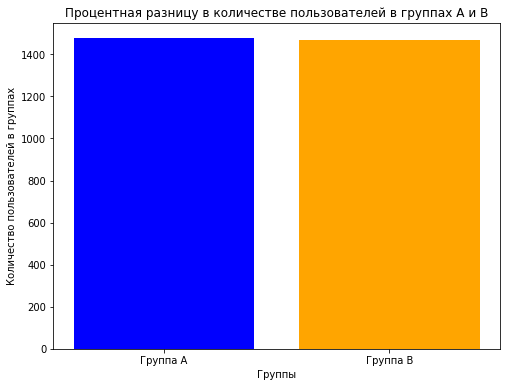

In [8]:
sessions_test_part = pd.read_csv('тут_была_ссылка')

unic_users_one_dei = sessions_test_part.groupby('test_group')['user_id'].nunique()

A = unic_users_one_dei['A']
B = unic_users_one_dei['B']
prosh = 100 * (A - B) / A if A > B else 100 * (B - A) / A

print(f'Процентная разница в группах состовляет{prosh}')

plt.figure(figsize=(8,6))
plt.bar(['Группа A', 'Группа B'], [A, B], color = ['blue', 'orange'])
plt.title('Процентная разницу в количестве пользователей в группах A и B')
plt.xlabel('Группы')
plt.ylabel('Количество пользователей в группах')

plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [9]:
Group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
Group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = set(Group_A) & set(Group_B)

print(f'Количество пользователей, которые встречаются одновременно в группах A и B = {len(intersection)}')

Количество пользователей, которые встречаются одновременно в группах A и B = 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


<Figure size 720x432 with 0 Axes>

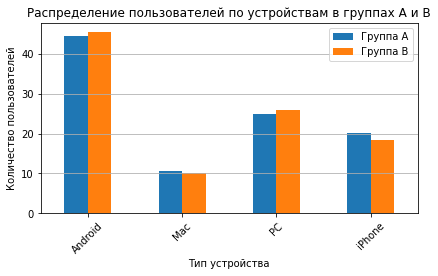

Распределение пользователей по устройствам:


,Группа A,Группа B
device,,
Android,44.41,45.57
Mac,10.56,10.10
PC,24.98,25.99
iPhone,20.04,18.35


In [10]:
device_stats = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().unstack()

device_pct_a = device_stats.loc['A'] / device_stats.loc['A'].sum() * 100
device_pct_b = device_stats.loc['B'] / device_stats.loc['B'].sum() * 100
device_pct = pd.DataFrame({'Группа A': device_pct_a, 'Группа B': device_pct_b})

plt.figure(figsize=(10, 6))
device_pct.plot(kind='bar')
plt.title('Распределение пользователей по устройствам в группах A и B')
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
plt.legend(['Группа A', 'Группа B'])
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

print('Распределение пользователей по устройствам:')
display(round(device_pct, 2))

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


<Figure size 864x432 with 0 Axes>

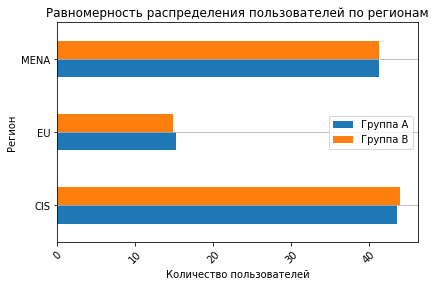

Распределение пользователей по регионам:


,Группа А,Группа Б
region,,
CIS,43.60,44.0
EU,15.17,14.8
MENA,41.23,41.2


In [11]:
reg_raspred = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack()

reg_raspred_a = reg_raspred.loc['A'] / reg_raspred.loc['A'].sum() * 100
reg_raspred_b = reg_raspred.loc['B'] / reg_raspred.loc['B'].sum() * 100

res_raspred_plt = pd.DataFrame({'Группа А': reg_raspred_a, 'Группа Б': reg_raspred_b})

plt.figure(figsize=(12,6))                                          
res_raspred_plt.plot(kind = 'barh')
plt.title('Равномерность распределения пользователей по регионам')
plt.xlabel('Количество пользователей')
plt.ylabel('Регион')
plt.legend(['Группа A', 'Группа B'])
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()     

print('Распределение пользователей по регионам:')
display(round(res_raspred_plt, 2))

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

##### Основываясь на проверки A/B-теста пришёл к следующим выводам:

При выполнении теста было проведено несколько важных шагов, таких как формулировка нулевой и альтернативной гипотезы,определилимь с целевой метрикой,рассчитали необходимый размер выборки,а также необходимую длительность теста.

Обноруженных различий в количестве пользователей в группах небыло,так же небыло обнаруженно пересечений пользователей из тестовой и контрольной группы что показывает нам что  A/B-тест проводился на независимых выборках и является репрезентативным.

Распределение пользователей тестовой и контрольной групп по категориальным переменным остаётся в целом равномерным,хоть и присутсвуют небольшие расхождения в этих показателях.Данные различиях в распределениях являются незначительными и не повлияют на результат теста.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `тут_была_ссылка`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [12]:
sessions_test = pd.read_csv('тут_была_ссылка')

sessions_test['good_session'] = (sessions_test['page_counter'] >=4).astype(int)

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

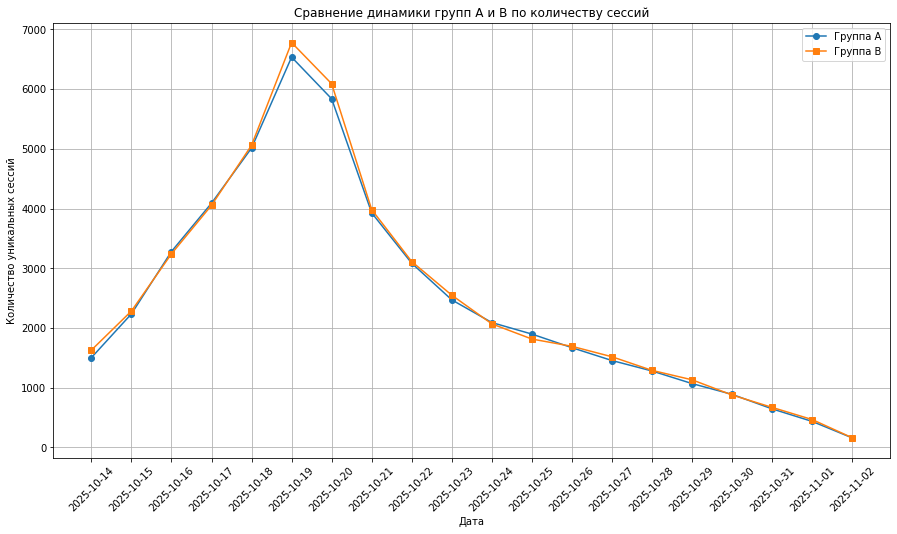

Результаты t-теста Уэлча:
p-value: 0.9382
Нет статистически значимых различий в количестве сессий между группами (p > 0.05)


In [13]:
df_grp = (sessions_test.groupby(['test_group', 'session_date']).agg({'session_id': 'nunique',}).reset_index())

x = df_grp.session_date.unique()
y_a = df_grp[df_grp.test_group == 'A'].session_id
y_b = df_grp[df_grp.test_group == 'B'].session_id

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label = 'Группа A', marker = 'o')
plt.plot(x, y_b, label = 'Группа B', marker = 's')

plt.xlabel('Дата')
plt.ylabel('Количество уникальных сессий')
plt.legend()
plt.title('Сравнение динамики групп A и B по количеству сессий')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

t_stat, p_value = stats.ttest_ind(y_a, y_b, equal_var=False)

print(f"Результаты t-теста Уэлча:")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("Нет статистически значимых различий в количестве сессий между группами (p > 0.05)")
else:
    print("Обнаружены статистически значимые различия в количестве сессий между группами (p <= 0.05)")

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [14]:
group_a_success = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
group_b_success = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()
difference = group_b_success - group_a_success

print(f"Доля успешных сессий в группе A: {group_a_success}")
print(f"Доля успешных сессий в группе B: {group_b_success}")
print(f"Разница (B - A): {difference}")

Доля успешных сессий в группе A: 0.3077233557344958
Доля успешных сессий в группе B: 0.31828992745867524
Разница (B - A): 0.010566571724179463


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [15]:
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].count()

success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].count()

z_stat, p_value = proportions_ztest([success_a, success_b], [total_a, total_b])

print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("Изменение не является статистически значимым")
else:
    print("Изменение статистически значимо")


p-value: 0.0003
Изменение статистически значимо


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

***В ходе проведения A/B теста было задействованно 82080 пользователей по 4140 в каждую группу.Оптимальная длителность теста по расчётам составила 9 дней.***

***Статистическое отличие есть.Количество успешных сесий в тестовой выборке выше примерно на 1.1%, а значение p-value составило 0.0003.***

**Статистическая значимость присутствует,что говорит о целеосообразности внедрения нового алгоритма.Могу рекомендовать внедрение нововведения в приложение.***